# Residuals linearity

|                |   |
:----------------|---|
| **Name**     | Eddie Aguilar  |
| **Date**      | 04/24/2025  |
| **ID** | 739352  | 

In [1]:
from xgboost import XGBRegressor
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import optuna

In [2]:
data = pd.read_csv(r"C:\Users\AgJo413\Documents\GitHub\Lab_std\labstds\Data\Advertising.csv")
data.head()

,Unnamed: 0,TV,radio,newspaper,sales
0,1,230.1,37.8,69.2,22.1
1,2,44.5,39.3,45.1,10.4
2,3,17.2,45.9,69.3,9.3
3,4,151.5,41.3,58.5,18.5
4,5,180.8,10.8,58.4,12.9


In [3]:
data['TV_radio'] = data['TV'] * data['radio']
data['TV_newspaper'] = data['TV'] * data['newspaper']
data['radio_newspaper'] = data['radio'] * data['newspaper']

X = data[["TV", "radio", "newspaper", "TV_radio", "TV_newspaper", "radio_newspaper"]]
y = data["sales"].to_frame()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

In [5]:
model = XGBRegressor(n_estimators = 10, max_depth = 10, max_leaves = 10)

In [6]:
model = model.fit(X = X_train, y =  y_train)


In [7]:
ypred = model.predict(X = X_test)

In [8]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R² score: {r2_train:.4f}")
print(f"Test R² score: {r2_test:.4f}")

Train R² score: 0.9943
Test R² score: 0.9823


## Hyperparameter optimization

In [9]:
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 2, 100)
    max_leaves = trial.suggest_int("max_leaves", 5, 100)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        max_leaves=max_leaves,
        random_state=42,
        verbosity=0
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return r2_score(y_test, y_pred)


In [10]:
# Run optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200)

[I 2025-04-24 17:51:36,931] A new study created in memory with name: no-name-600b458e-9ff9-4256-b3dd-38b878bb5c39
[I 2025-04-24 17:51:37,011] Trial 0 finished with value: 0.9801681041717529 and parameters: {'n_estimators': 121, 'max_depth': 21, 'max_leaves': 57}. Best is trial 0 with value: 0.9801681041717529.
[I 2025-04-24 17:51:37,092] Trial 1 finished with value: 0.9801681041717529 and parameters: {'n_estimators': 174, 'max_depth': 55, 'max_leaves': 72}. Best is trial 0 with value: 0.9801681041717529.
[I 2025-04-24 17:51:37,156] Trial 2 finished with value: 0.9801681041717529 and parameters: {'n_estimators': 98, 'max_depth': 100, 'max_leaves': 68}. Best is trial 0 with value: 0.9801681041717529.
[I 2025-04-24 17:51:37,229] Trial 3 finished with value: 0.9801071286201477 and parameters: {'n_estimators': 173, 'max_depth': 9, 'max_leaves': 53}. Best is trial 0 with value: 0.9801681041717529.
[I 2025-04-24 17:51:37,326] Trial 4 finished with value: 0.9801681041717529 and parameters: {'n

In [11]:
# Best parameters
best_params = study.best_params
print("Best hyperparameters:", best_params)

Best hyperparameters: {'n_estimators': 109, 'max_depth': 4, 'max_leaves': 6}


In [12]:
best_model = XGBRegressor(**best_params, random_state=42, verbosity=0)
best_model = best_model.fit(X_train, y_train)

In [13]:
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print(f"Train R² score: {r2_train:.4f}")
print(f"Test R² score: {r2_test:.4f}")

Train R² score: 1.0000
Test R² score: 0.9837


Now, we have to check if it is linear the relations in the residuals, let's plot them:

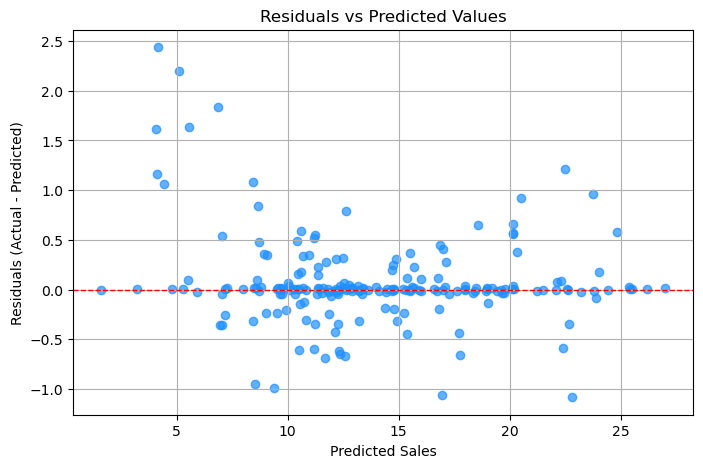

In [14]:
import matplotlib.pyplot as plt

# Predict the entire dataset
y_pred_all = best_model.predict(X)
residuals = y.values.flatten() - y_pred_all

# Scatter plot: Predicted vs Residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_all, residuals, alpha=0.7, color='dodgerblue')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Residuals vs Predicted Values")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.grid(True)
plt.show()


Are the residuals linearly related to the predictions?

To check whether there's a linear relationship between the residuals and the predicted values, we can fit a simple linear regression model:


In a well-behaved regression model, the residuals should have no linear (or any) pattern when plotted against the predicted values. This means:

Ideally, the slope 
𝛽
1
​
  should be close to zero.

The regression line should appear flat, indicating no systematic error across the predicted range.

If we observe a clear slope or pattern, it may suggest:

Model misspecification (e.g. missing nonlinear terms),

Heteroscedasticity (non-constant variance),

Or interactions that weren’t properly modeled.

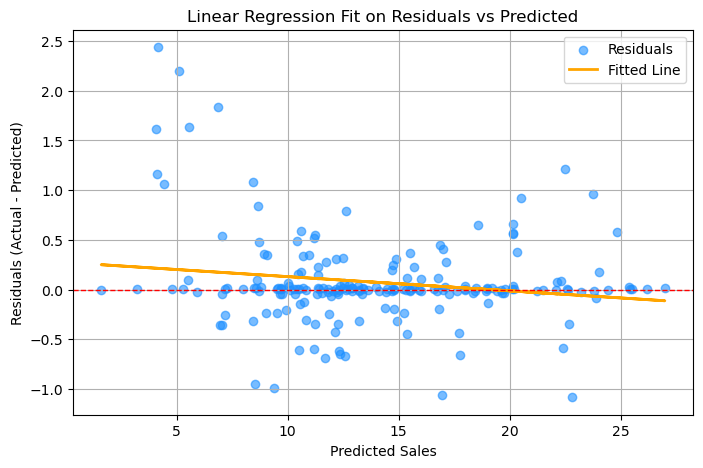

Regression Slope (Beta 1): -0.014295
Regression Intercept (Beta 0): 0.272992


In [15]:
from sklearn.linear_model import LinearRegression

X_lin = y_pred_all.reshape(-1, 1)
y_lin = residuals.reshape(-1, 1)

lin_model = LinearRegression()
lin_model.fit(X_lin, y_lin)

residuals_fit = lin_model.predict(X_lin)

plt.figure(figsize=(8, 5))
plt.scatter(y_pred_all, residuals, alpha=0.6, color='dodgerblue', label='Residuals')
plt.plot(y_pred_all, residuals_fit, color='orange', linewidth=2, label='Fitted Line')
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.title("Linear Regression Fit on Residuals vs Predicted")
plt.xlabel("Predicted Sales")
plt.ylabel("Residuals (Actual - Predicted)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Regression Slope (Beta 1): {lin_model.coef_[0][0]:.6f}")
print(f"Regression Intercept (Beta 0): {lin_model.intercept_[0]:.6f}")


In [16]:
import statsmodels.api as sm

X_sm = sm.add_constant(X_lin)
model_sm = sm.OLS(y_lin, X_sm).fit()

# Display summary
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     5.534
Date:                Thu, 24 Apr 2025   Prob (F-statistic):             0.0196
Time:                        17:51:54   Log-Likelihood:                -123.99
No. Observations:                 200   AIC:                             252.0
Df Residuals:                     198   BIC:                             258.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2730      0.091      3.013      0.0

### Conclusion: Linearity of Residuals

To evaluate whether the residuals from the XGBoost model have a linear relationship with the predicted values, we performed a linear regression of the residuals against the predictions. The purpose was to test the null hypothesis:

- **H₀**: The slope (β₁) is equal to 0, meaning there is no linear relationship.
- **H₁**: The slope (β₁) is different from 0, indicating a linear relationship.

The resulting p-value for the slope was 0.020, which is statistically significant at the 5% level. Therefore, we reject the null hypothesis and conclude that there is a small but statistically significant linear trend in the residuals.

This indicates that while the model captures most of the variability in the data, some systematic structure remains unaccounted for. This may suggest the presence of non-linear effects or missing interactions that the model did not fully capture.

Although the XGBoost model performs well overall, the presence of this trend suggests there is still room for improvement, potentially through additional feature engineering or further model tuning.
